# Uplift modelling for Direct Marketing

**References**

- [Rubin Causal Model](https://en.wikipedia.org/wiki/Rubin_causal_model)
- [Stochastic solutions MineThatData Email Analytics Challenge (2008)](http://minethatdata.com/Stochastic_Solutions_E-Mail_Challenge_2008.04.30.pdf)
- [Athey and Imbens (2015)](https://pdfs.semanticscholar.org/86ce/004214845a1683d59b64c4363a067d342cac.pdf)
- [Pylift blog post (2018)](https://tech.wayfair.com/data-science/2018/10/pylift-a-fast-python-package-for-uplift-modeling/)
- [Ascarza (2018)](https://journals.sagepub.com/doi/full/10.1509/jmr.16.0163)
- [Gutierrez and Gerardy (2017)](http://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf)
- [Kunzel et al (2019)](https://arxiv.org/pdf/1706.03461.pdf)
- [Rzepakowski and Jaroszewicz (2012)](https://pdfs.semanticscholar.org/e979/ba084f34345b2ac8783df2b4a3295ae9273f.pdf)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylift import TransformedOutcome
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, reciprocal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import t
from sklearn.preprocessing import LabelEncoder
plt.style.use('fivethirtyeight')

c:\users\wongt\desktop\projects\uplift_modelling\um_env\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<br>
<br>

## The data

In [2]:
df = pd.read_csv("data/hillstrom/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [3]:
df.visit.value_counts()

0    54606
1     9394
Name: visit, dtype: int64

In [4]:
df.conversion.value_counts()

0    63422
1      578
Name: conversion, dtype: int64

Only 578 customers made purchases, a rather low conversion rate

<br>
<br>

### Population average treatment effects of the E-Mail campaign

The Population Average Treatment Effect of the E-Mail campaign overall is:

$$\tau^{p} = \mathbb E[Y_t - Y_c] =  \mathbb E[Y_t] -  \mathbb E[Y_c]$$

where $Y \in \{ 0, 1 \} $ is equal to $1$ if the customer purchases and $0$ otherwise while $t$ and $c$ indicate the treatment and control groups respectively. 

In a randomized experiment where the E-Mail campaign is randomized across a representative sample of customers, the populatation average treatment effect can be estimated by taking the difference between the average treated and control group outcomes. This is because, outside of the treatment, the two groups of customers are comparable in terms of their features.

Like for an A/B test, this is what's used to determine whether the E-Mail campaign was a success overall. Was there a (statistically/practically significant) uplift in visits, purchases, or sales as a result of the E-Mail campaign?

**On visits**

In [5]:
mens = df[df.segment=="Mens E-Mail"].visit.mean()*100
womens = df[df.segment=="Womens E-Mail"].visit.mean()*100
control = df[df.segment=="No E-Mail"].visit.mean()*100
print("Men's E-Mail visit rate: {:.2f}%".format(mens))
print("Women's E-Mail visit rate: {:.2f}%".format(womens))
print("Control E-mail visit Rate: {:.2f}%".format(control))
print("---------------------------------")
print("Men's visit rate uplift: {:.2f}%".format(mens-control))
print("Womens's visit rate uplift: {:.2f}%".format(womens-control))

Men's E-Mail visit rate: 18.28%
Women's E-Mail visit rate: 15.14%
Control E-mail visit Rate: 10.62%
---------------------------------
Men's visit rate uplift: 7.66%
Womens's visit rate uplift: 4.52%


**On conversion**

In [6]:
mens = df[df.segment=="Mens E-Mail"].conversion.mean()*100
womens = df[df.segment=="Womens E-Mail"].conversion.mean()*100
control = df[df.segment=="No E-Mail"].conversion.mean()*100
print("Men's E-Mail conversion rate: {:.2f}%".format(mens))
print("Women's E-Mail conversion rate: {:.2f}%".format(womens))
print("Control E-mail conversion Rate: {:.2f}%".format(control))
print("---------------------------------")
print("Men's conversion rate uplift: {:.2f}%".format(mens-control))
print("Womens's conversion rate uplift: {:.2f}%".format(womens-control))

Men's E-Mail conversion rate: 1.25%
Women's E-Mail conversion rate: 0.88%
Control E-mail conversion Rate: 0.57%
---------------------------------
Men's conversion rate uplift: 0.68%
Womens's conversion rate uplift: 0.31%


**On spending**

In [7]:
mens = df[df.segment=="Mens E-Mail"].spend.mean()
womens = df[df.segment=="Womens E-Mail"].spend.mean()
control = df[df.segment=="No E-Mail"].spend.mean()
print("Men's E-Mail spending: ${:.2f}".format(mens))
print("Women's E-Mail spending: ${:.2f}".format(womens))
print("Control E-mail spending: ${:.2f}".format(control))
print("---------------------------------")
print("Men's spending uplift: ${:.2f}".format(mens-control))
print("Womens's spending uplift: ${:.2f}".format(womens-control))

Men's E-Mail spending: $1.42
Women's E-Mail spending: $1.08
Control E-mail spending: $0.65
---------------------------------
Men's spending uplift: $0.77
Womens's spending uplift: $0.42


<br>
<br>

### Aside - Different formulation

Customers only spend money if they make a purchase (conversion) and they only make a purchase if they visit the website (visit). Therefore a natural way to decompose the uplifts is with the following:

$$\mathbb E[\text{spend}] = \mathbb E[\text{spend|purchase}] \times \text{P}(\text{purchase|visit}) \times \text{P}(\text{visit})$$

In [8]:
print("Mens average spend given purchase: ${:.2f}".format(df[(df.conversion==1) & (df.segment=='Mens E-Mail')].spend.mean()))
print("Womens average spend given purchase: ${:.2f}".format(df[(df.conversion==1) & (df.segment=='Womens E-Mail')].spend.mean()))
print("Control average spend given purchase: ${:.2f}".format(df[(df.conversion==1) & (df.segment=='No E-Mail')].spend.mean()))

Mens average spend given purchase: $113.53
Womens average spend given purchase: $121.89
Control average spend given purchase: $114.00


In [9]:
print("Mens purchase rate given visit: {:.2f}%".format(100*(len(df[(df.conversion==1) & (df.segment=='Mens E-Mail')]) / len(df[(df.visit==1) & (df.segment=='Mens E-Mail')]))))
print("Womens purchase rate given visit: {:.2f}%".format(100*(len(df[(df.conversion==1) & (df.segment=='Womens E-Mail')]) / len(df[(df.visit==1) & (df.segment=='Womens E-Mail')]))))
print("Control purchase rate given visit: {:.2f}%".format(100*(len(df[(df.conversion==1) & (df.segment=='No E-Mail')]) / len(df[(df.visit==1) & (df.segment=='No E-Mail')]))))

Mens purchase rate given visit: 6.86%
Womens purchase rate given visit: 5.84%
Control purchase rate given visit: 5.39%


In [10]:
print("Mens visit rate: {:.2f}%".format(100*(len(df[(df.visit==1) & (df.segment=='Mens E-Mail')]) / len(df[(df.segment=='Mens E-Mail')]))))
print("Womens visit rate: {:.2f}%".format(100*(len(df[(df.visit==1) & (df.segment=='Womens E-Mail')]) / len(df[(df.segment=='Womens E-Mail')]))))
print("Control visit rate: {:.2f}%".format(100*(len(df[(df.visit==1) & (df.segment=='No E-Mail')]) / len(df[(df.segment=='No E-Mail')]))))

Mens visit rate: 18.28%
Womens visit rate: 15.14%
Control visit rate: 10.62%


Multiplying the corresponding quantities above gives:

In [11]:
print("Mens mean spend: ${:.2f}".format(df[(df.segment=='Mens E-Mail')].spend.mean()))
print("Womens mean spend: ${:.2f}".format(df[(df.segment=='Womens E-Mail')].spend.mean()))
print("Control mean spend: ${:.2f}".format(df[(df.segment=='No E-Mail')].spend.mean()))

Mens mean spend: $1.42
Womens mean spend: $1.08
Control mean spend: $0.65


aka spend per head, as per the formulation above

<br>
<br>

### Conditional Average Treatment Effects (CATE)

On average there was an uplift in visit rate and expenditure across the population, however different individuals should react differently to any given intervention. Some customers are more persuadable than others, some will purchase regardless of the E-Mail, whilst others will not purchase regardless of whether they are targeted or not (See section 3 of [this paper](http://stochasticsolutions.com/pdf/CrossSell.pdf)).

To incorporate this type of customer heterogeneity, we instead need to model an individual customer's treatment effect conditional on their features i.e. the conditional average treatment effect. We are assuming that a customer's features $x$ are predictive of whether or not the E-Mail campaign will have a positive effect on them. 

This is where **uplift modelling** comes in.

We build a model that identifies subpopulations of customers for which the treatment will have the largest uplift. That way we can ensure the largest ROI by only targeting groups of customers that are most likely to respond positively to marketing campaigns.

Mathematically, we target customers whose conditional average treatment effect (CATE) is larger than the population average treatment effect

$$ \tau^{(i)} = E[ Y_{t}^{(i)} - Y_{c}^{(i)}| \mathbf{x}^{(i)} ] > \tau^{p}$$

where $\mathbf{x^{(i)}}$ is a particular realization of the set of customer features for customer $i$. 

The model will rank customers by uplift in a descending manner and we will investigate the cumulative uplift (or "gain") of the outcome when targeting increasing proportions of the subpopulation from largest uplift to smallest.

<br>
<br>

### Build Uplift & Response models for Women's Visit Rate

**Why only model uplift for visit rate?**

Due to the low conversion rates of the E-Mail campaign, the stability of purchase (conversion) uplift is not robust to sampling. In other words after performing a train/test split and producing 10% deciles, the variance of the uplift for conversion has high variance and is likely not going to be significantly different from 0. 

Also from the formulation above it can be seen that the increase in mean spending due to the E-Mails (compared to the control group) for women and particularly for men is dominated by an increase in visit rate. Hence it is an obvious candidate for uplift modelling; which customers will have the largest gain in visit probability and hence spending due to receiving the E-Mail?.

See Section 4 and section 5.2 of [Stochastic Solutions (2008)](http://minethatdata.com/Stochastic_Solutions_E-Mail_Challenge_2008.04.30.pdf) for more details

In [12]:
mens_df = df[df.segment!='Womens E-Mail'].copy()
womens_df = df[df.segment!='Mens E-Mail'].copy()

# Label encode segment as treatment column
mens_df.segment.replace({'Mens E-Mail':1, 'No E-Mail':0}, inplace=True)
womens_df.segment.replace({'Womens E-Mail':1, 'No E-Mail':0}, inplace=True)

# Drop conversion and spend outcomes
mens_df.drop(columns=['conversion', 'spend'], inplace=True)
womens_df.drop(columns=['conversion', 'spend'], inplace=True)

# Ordinal encode "history_segment"
hist_seg_map = {
    "1) $0 - $100":1,
    "2) $100 - $200":2,
    "3) $200 - $350":3,
    "4) $350 - $500":4,
    "5) $500 - $750":5,
    "6) $750 - $1,000":6,
    "7) $1,000 +":7
}

mens_df.history_segment.replace(hist_seg_map, inplace=True)
womens_df.history_segment.replace(hist_seg_map, inplace=True)

# # OHE categorical variables
# mens_df = pd.get_dummies(mens_df)
# womens_df = pd.get_dummies(womens_df)

# Integer Encode
mens_df.zip_code = LabelEncoder().fit_transform(mens_df.zip_code)
mens_df.channel = LabelEncoder().fit_transform(mens_df.channel)
womens_df.zip_code = LabelEncoder().fit_transform(womens_df.zip_code)
womens_df.channel = LabelEncoder().fit_transform(womens_df.channel)

# Label treatment and outcome columns
mens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)
womens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)

state = 7

# Build Uplift model using pylift package
up1 = TransformedOutcome(womens_df,
                         col_treatment='Treatment',
                         col_outcome='Outcome',
                         stratify=womens_df['Treatment'],
                         test_size=0.5,
                         continuous_outcome=False,
                         sklearn_model=RandomForestRegressor,
                         random_state=state
                        )

___

In [ ]:
# RandomizedSearchCV - BEST PARAMETERS FOUND BELOW ALREADY
up1.randomized_search(param_distributions={'max_depth': range(3,120),
                                           'min_samples_split': range(500,2000),
                                           'max_features':['auto', 'sqrt'],
                                           'n_estimators': range(3,200),
                                           'random_state': [state]
                                          },
                      n_iter=400,
                      cv=5,
                      n_jobs=6,
                      random_state=state
                     )

up1.rand_search_.best_params_

___

In [13]:
best_params = {'random_state': state,
 'n_estimators': 40,
 'min_samples_split': 4800,
 'max_features': 'sqrt',
 'max_depth': 9}

up1.fit(**best_params)

**Evaluate uplift model**

In [14]:
womens_treated_visit_rate = up1.df_test[up1.df_test.Treatment==1].Outcome.mean()*100
womens_untreated_visit_rate = up1.df_test[up1.df_test.Treatment==0].Outcome.mean()*100
average_treatment_effect = womens_treated_visit_rate - womens_untreated_visit_rate
print("Womens's test set visit rate uplift: {:.2f}%".format(average_treatment_effect))

Womens's test set visit rate uplift: 5.28%


Cumulative Gain AUC: 0.01031
Cumulative Gain AUC: 0.01000


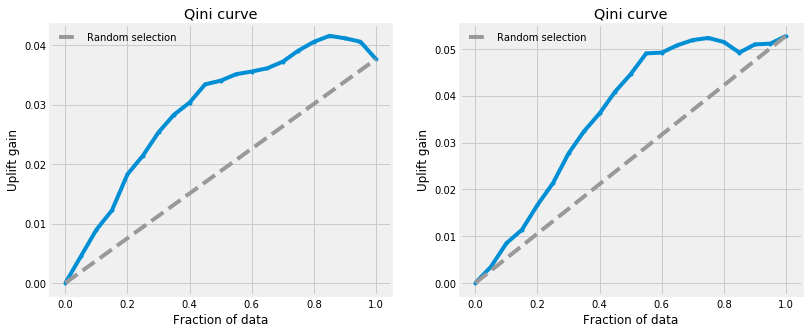

In [15]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
up1.train_results_.plot('qini', ax=ax, show_random_selection=True);

ax = fig.add_subplot(122)
up1.test_results_.plot('qini', ax=ax, show_random_selection=True);

print("Cumulative Gain AUC: {:.5f}".format(up1.train_results_.Q_qini))
print("Cumulative Gain AUC: {:.5f}".format(up1.test_results_.Q_qini))

<br>
<br>

**Build response model**



I follow the methodology and nomenclature of the analysis performed by [Ascarza (2018)](https://journals.sagepub.com/doi/full/10.1509/jmr.16.0163). As a result I use the terms "response model" and "risk model" interchangeably however they mean exactly the same thing in this context. In churn prediction parlance, a risk model is used to compute the probability of customer churn i.e. risk of churning. In this case the risk model is used to compute the propensity to visit the site thus the "risk" of visiting.

In [16]:
# Train on control group in calibration set, predict on treatment and control group in validation set
train_df = up1.df_train[up1.df_train.Treatment==1].copy()
test_df = up1.df_test.copy()

# Drop other outcomes
train_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)
test_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)

# Set up train/test df
train_label = train_df.Outcome
test_label = test_df.Outcome
train_df = train_df.drop(columns='Outcome')
test_df = test_df.drop(columns='Outcome')

In [17]:
risk_model = RandomForestClassifier(n_estimators=1500, max_depth=7, max_features='auto')
risk_model.fit(train_df, train_label)
y_pred_risk = risk_model.predict_proba(test_df)[:,1]

results_df = up1.df_test.copy()
results_df['risk'] = y_pred_risk
results_df['uplift'] = up1.transformed_y_test_pred
results_df['risk_decile'] = pd.qcut(y_pred_risk, 10)
results_df['uplift_decile'] = pd.qcut(up1.transformed_y_test_pred, 10)

del y_pred_risk

In [18]:
results_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,Treatment,Outcome,TransformedOutcome,risk,uplift,risk_decile,uplift_decile
57923,1,1,70.76,0,1,2,0,2,1,0,0,0.199189,0.047421,"(0.195, 0.219]","(0.0461, 0.0518]"
20210,4,4,431.55,0,1,1,0,0,0,1,-2.0038,0.241916,0.060727,"(0.219, 0.393]","(0.0567, 0.0626]"
43389,8,1,83.01,1,0,2,0,2,1,0,0,0.148192,0.016417,"(0.144, 0.159]","(0.0142, 0.0188]"
36893,7,1,47.78,1,0,1,1,2,1,0,0,0.077302,0.024784,"(0.0375, 0.0797]","(0.0233, 0.0275]"
20551,6,2,170.30,0,1,1,0,1,0,0,-0,0.191000,0.058010,"(0.175, 0.195]","(0.0567, 0.0626]"


<br>
<br>

### Comparison of visit rates between risk and uplift model

In [19]:
def compute_treatment_effect(results, for_risk=True):
    if for_risk:
        targeting_strategy = 'risk_decile'
    else:
        targeting_strategy = 'uplift_decile'
    treated_customers = results[results.Treatment==1]
    control_customers = results[results.Treatment==0]
    treated_visit_rates = ( \
                            treated_customers.groupby(targeting_strategy)['Outcome'].sum() / \
                            treated_customers.groupby(targeting_strategy)['Outcome'].count() \
                          ) * 100
    control_visit_rates = ( \
                            control_customers.groupby(targeting_strategy)['Outcome'].sum() / \
                            control_customers.groupby(targeting_strategy)['Outcome'].count() \
                          ) * 100
    te = pd.DataFrame(treated_visit_rates - control_visit_rates).reset_index()
    te[targeting_strategy] = te[targeting_strategy].astype(str)
    te.columns = [targeting_strategy, 'Treatment_Effect']
    return te


def compute_visit_rates(results, for_risk=True):   
    if for_risk:
        targeting_strategy = 'risk_decile'
    else:
        targeting_strategy = 'uplift_decile'
    treated_customers = results[results.Treatment==1]
    control_customers = results[results.Treatment==0]
    treated_visit_rates = ( \
                            treated_customers.groupby(targeting_strategy)['Outcome'].sum() / \
                            treated_customers.groupby(targeting_strategy)['Outcome'].count() \
                          ) * 100
    control_visit_rates = ( \
                            control_customers.groupby(targeting_strategy)['Outcome'].sum() / \
                            control_customers.groupby(targeting_strategy)['Outcome'].count() \
                          ) * 100
    treated_visit_rates = pd.DataFrame(treated_visit_rates).reset_index()
    treated_visit_rates[targeting_strategy] = treated_visit_rates[targeting_strategy].astype(str)
    treated_visit_rates.columns = [targeting_strategy, 'visit_rate']
    control_visit_rates = pd.DataFrame(control_visit_rates).reset_index()
    control_visit_rates[targeting_strategy] = control_visit_rates[targeting_strategy].astype(str)
    control_visit_rates.columns = [targeting_strategy, 'visit_rate']                 
    return treated_visit_rates, control_visit_rates

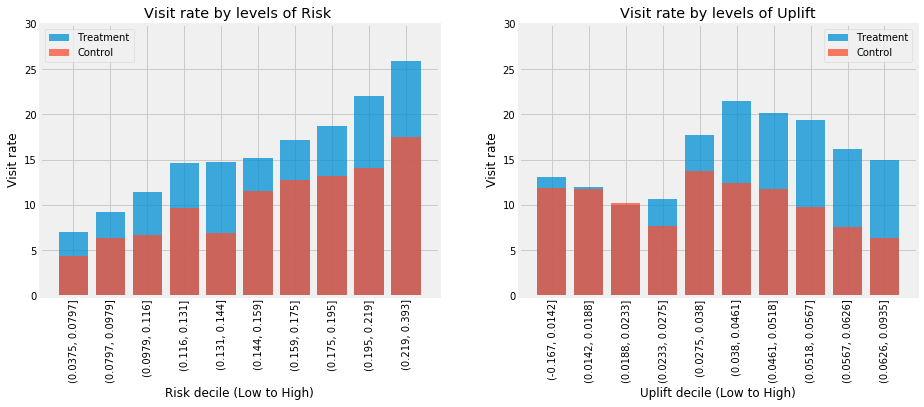

In [20]:
risk_treatment, risk_control = compute_visit_rates(results_df)
uplift_treatment, uplift_control = compute_visit_rates(results_df, for_risk=False)

fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.bar(risk_treatment.risk_decile.values, risk_treatment.visit_rate.values, label='Treatment', alpha=0.75)
ax1.bar(risk_control.risk_decile.values, risk_control.visit_rate.values, label='Control', alpha=0.75)
ax1.set_ylabel("Visit rate")
ax1.set_xlabel("Risk decile (Low to High)")
ax1.legend()
ax1.set_title("Visit rate by levels of Risk ")
plt.xticks(rotation='vertical')
ax1.set_ylim(0,30)

ax2 = fig.add_subplot(122)
ax2.bar(uplift_treatment.uplift_decile.values, uplift_treatment.visit_rate.values, label='Treatment', alpha=0.75)
ax2.bar(uplift_control.uplift_decile.values, uplift_control.visit_rate.values, label='Control', alpha=0.75)
ax2.set_ylabel("Visit rate")
ax2.set_xlabel("Uplift decile (Low to High)")
ax2.legend()
ax2.set_title("Visit rate by levels of Uplift")
plt.xticks(rotation='vertical')
ax2.set_ylim(0,30);

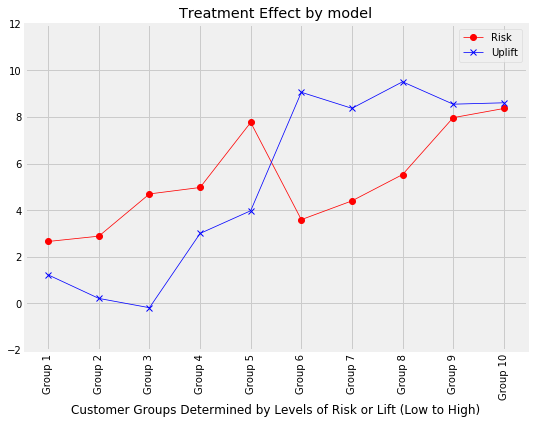

In [21]:
group_labels = ['Group ' + str(group) for group in list(range(1,11))]
risk_te = compute_treatment_effect(results_df)
risk_te['group'] = group_labels
uplift_te = compute_treatment_effect(results_df, for_risk=False)
uplift_te['group'] = group_labels

plt.figure(figsize=(8,6))
plt.plot(risk_te.group.values, risk_te.Treatment_Effect.values, 'ro-', linewidth=0.75, label='Risk')
plt.plot(uplift_te.group.values, uplift_te.Treatment_Effect.values, 'bx-', linewidth=0.75, label='Uplift')
plt.ylim(-2,12)
plt.xticks(rotation='vertical')
plt.xlabel("Customer Groups Determined by Levels of Risk or Lift (Low to High)")
plt.legend()
plt.title("Treatment Effect by model");

<br>
<br>

### impact of Direct Marketing campaign

- For risk model: Target customers with highest probability of visiting first
- For uplift model: Target customers with highest uplift first

In [22]:
def compute_pooled_proportion(p1, n1, p2, n2):
    return ((p1*n1)+(p2*n2)) / (n1+n2)

def compute_se(p, n1, n2):
    return np.sqrt(p*(1-p)*((1/n1)+(1/n2)))

def compute_impact(results, for_risk=True):
    if for_risk:
        targeting_strategy = 'risk_decile'
    else:
        targeting_strategy = 'uplift_decile'
    treated_customers = results[results.Treatment==1]
    control_customers = results[results.Treatment==0]
    
    treated_visit = (treated_customers.groupby(targeting_strategy)['Outcome'].sum()) 
    treated_total = (treated_customers.groupby(targeting_strategy)['Outcome'].count()) 
    control_visit = (control_customers.groupby(targeting_strategy)['Outcome'].sum())
    control_total = (control_customers.groupby(targeting_strategy)['Outcome'].count()) 
    
    treated_visit = pd.DataFrame(treated_visit).reset_index()
    treated_visit[targeting_strategy] = treated_visit[targeting_strategy].astype(str)
    treated_visit.columns = [targeting_strategy, 'visited']
    treated_visit['total'] = treated_total.values
    
    control_visit = pd.DataFrame(control_visit).reset_index()
    control_visit[targeting_strategy] = control_visit[targeting_strategy].astype(str)
    control_visit.columns = [targeting_strategy, 'visited']
    control_visit['total'] = control_total.values
    
#     # Target high uplift, low risk first
#     if not for_risk:
#         treated_visit, control_visit = treated_visit.iloc[::-1], control_visit.iloc[::-1]
    
    # Target high uplift, high risk first
    treated_visit, control_visit = treated_visit.iloc[::-1], control_visit.iloc[::-1]
        
    treated_visit['visit_cumsum'] = treated_visit.visited.cumsum()
    treated_visit['total_cumsum'] = treated_visit.total.cumsum()
    treated_visit['cumsum_visit_rate'] = treated_visit.visit_cumsum / treated_visit.total_cumsum
    control_visit['visit_cumsum'] = control_visit.visited.cumsum()
    control_visit['total_cumsum'] = control_visit.total.cumsum()
    control_visit['cumsum_visit_rate'] = control_visit.visit_cumsum / control_visit.total_cumsum
    
    impact_df = treated_visit[[targeting_strategy]].copy()
    impact_df['cumsum_treatment_effect'] = treated_visit.cumsum_visit_rate - control_visit.cumsum_visit_rate
    
    p1, p2 = treated_visit.cumsum_visit_rate, control_visit.cumsum_visit_rate
    n1, n2 = treated_visit.total_cumsum, control_visit.total_cumsum
    
    impact_df['pooled_cumsum_proportion'] = compute_pooled_proportion(p1, n1, p2, n2)
    impact_df['standard_error'] = compute_se(impact_df['pooled_cumsum_proportion'].values, n1, n2)

    return impact_df, treated_visit, control_visit

In [23]:
risk_impact_df, _, _ = compute_impact(results_df, for_risk=True)
uplift_impact_df, _, _ = compute_impact(results_df, for_risk=False)

group_labels = [str(group*10)+'%' for group in list(range(1,11))]
risk_impact_df['group'] = group_labels
uplift_impact_df['group'] = group_labels

Recall average Treatment Effect in test data

In [24]:
print("Womens's test set visit rate uplift: {:.2f}%".format(average_treatment_effect))

Womens's test set visit rate uplift: 5.28%


This is the visit rate uplift we expect when randomly targeting customers

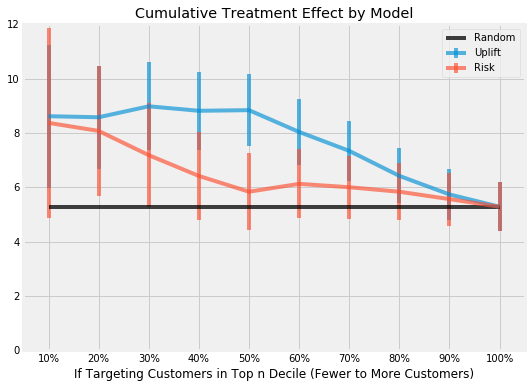

In [25]:
plt.figure(figsize=(8,6))
plt.errorbar(uplift_impact_df.group, uplift_impact_df.cumsum_treatment_effect*100, (uplift_impact_df.standard_error*100*1.96), label='Uplift', alpha=0.65)
plt.errorbar(risk_impact_df.group, risk_impact_df.cumsum_treatment_effect*100, (risk_impact_df.standard_error*100*1.96), label='Risk', alpha=0.65)
plt.ylim(0,12)
plt.xlabel("If Targeting Customers in Top n Decile (Fewer to More Customers)")
plt.hlines(average_treatment_effect, 0, 9, label='Random', alpha=0.75)
plt.xlim(-0.5,9.5)
plt.title("Cumulative Treatment Effect by Model")
plt.legend();

<br>
<br>

### Customer characteristics by uplift

In [ ]:
feat_names = list(results_df.drop(columns=['TransformedOutcome', 'Treatment', 'Outcome', 'risk', 'uplift', 'risk_decile']).columns)

avg_by_uplift_decile = results_df[feat_names].groupby('uplift_decile').mean().reset_index()
columns = []
feats = []
for col in avg_by_uplift_decile.columns:
    if col[1] == '':
        columns.append(col[0])
    else:
        feats.append(col[0])
        columns.append(col[0]+'_'+col[1])

avg_by_uplift_decile['uplift_decile'] = avg_by_uplift_decile['uplift_decile'].astype(str)
group_labels = ['Group ' + str(group) for group in list(range(1,11))]
avg_by_uplift_decile['group'] = group_labels
avg_by_uplift_decile = avg_by_uplift_decile.iloc[::-1]


fig = plt.figure(figsize=(16,12))
for idx, col in enumerate(avg_by_uplift_decile.iloc[:,1:13]):
    ax = fig.add_subplot(3,4,idx+1)
    ax.set_xlabel('Decile Groups (High Uplift to Low Uplift)')
    ax.set_title(col)
    ax.plot(avg_by_uplift_decile.group, avg_by_uplift_decile[col], 'bx-', linewidth=1, alpha=0.75)
    plt.xticks(rotation='vertical')
    plt.hlines(results_df[col].mean(), 0, 9, label='Average', alpha=0.75, linewidth=1.5)
    plt.legend()
plt.tight_layout()

<br>
<br>

### Build Uplift & Response models for Men's Visit Rate

In [11]:
mens_df = df[df.segment!='Womens E-Mail'].copy()
womens_df = df[df.segment!='Mens E-Mail'].copy()

# Label encode segment as treatment column
mens_df.segment.replace({'Mens E-Mail':1, 'No E-Mail':0}, inplace=True)
womens_df.segment.replace({'Womens E-Mail':1, 'No E-Mail':0}, inplace=True)

# Drop conversion and spend outcomes
mens_df.drop(columns=['conversion', 'spend'], inplace=True)
womens_df.drop(columns=['conversion', 'spend'], inplace=True)

# Ordinal encode "history_segment"
hist_seg_map = {
    "1) $0 - $100":1,
    "2) $100 - $200":2,
    "3) $200 - $350":3,
    "4) $350 - $500":4,
    "5) $500 - $750":5,
    "6) $750 - $1,000":6,
    "7) $1,000 +":7
}

mens_df.history_segment.replace(hist_seg_map, inplace=True)
womens_df.history_segment.replace(hist_seg_map, inplace=True)

# # OHE categorical variables
# mens_df = pd.get_dummies(mens_df)
# womens_df = pd.get_dummies(womens_df)

# Integer Encode
mens_df.zip_code = LabelEncoder().fit_transform(mens_df.zip_code)
mens_df.channel = LabelEncoder().fit_transform(mens_df.channel)
womens_df.zip_code = LabelEncoder().fit_transform(womens_df.zip_code)
womens_df.channel = LabelEncoder().fit_transform(womens_df.channel)

# Label treatment and outcome columns
mens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)
womens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)

state = 5

# Build Uplift model using pylift package
up2 = TransformedOutcome(mens_df,
                         col_treatment='Treatment',
                         col_outcome='Outcome',
                         stratify=mens_df['Treatment'],
                         test_size=0.5,
                         continuous_outcome=False,
                         sklearn_model=RandomForestRegressor,
                         random_state=state
                        )

___

In [ ]:
# RandomizedSearchCV. BEST PARAMS FOUND BELOW ALREADY
up2.randomized_search(param_distributions={'max_depth': range(3,15),
#                                            'min_samples_split': range(500,1800),
                                           'max_features':['auto', 'sqrt'],
                                           'n_estimators': range(3,150),
                                           'random_state': [state]
                                          },
                      n_iter=250,
                      cv=5,
                      n_jobs=1,
                      random_state=state,
                      verbose=1
                     )

up2.rand_search_.best_params_

___

Cumulative Gain AUC: 0.01420
Cumulative Gain AUC: 0.00133


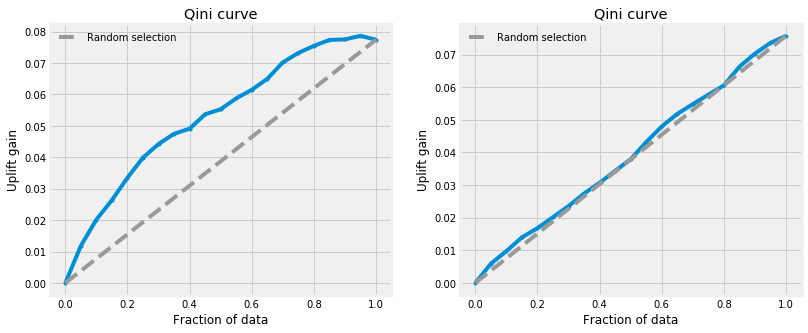

In [16]:
best_params = {'random_state': 5,
 'n_estimators': 50,
 'min_samples_split': 3000,
 'max_features': 'sqrt',
 'max_depth': 8}

up2.fit(**best_params)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
up2.train_results_.plot('qini', ax=ax, show_random_selection=True);

ax = fig.add_subplot(122)
up2.test_results_.plot('qini', ax=ax, show_random_selection=True);

print("Cumulative Gain AUC: {:.5f}".format(up2.train_results_.Q_qini))
print("Cumulative Gain AUC: {:.5f}".format(up2.test_results_.Q_qini))

<br>
<br>

In [28]:
# Train on control group in calibration set, predict on treatment and control group in validation set
train_df = up2.df_train[up2.df_train.Treatment==1].copy()
test_df = up2.df_test.copy()

# Drop other outcomes
train_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)
test_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)

# Set up train/test df
train_label = train_df.Outcome
test_label = test_df.Outcome
train_df = train_df.drop(columns='Outcome')
test_df = test_df.drop(columns='Outcome')

In [29]:
risk_model = RandomForestClassifier(n_estimators=1500, max_depth=7, max_features='auto')
risk_model.fit(train_df, train_label)
y_pred_risk = risk_model.predict_proba(test_df)[:,1]

results_df = up2.df_test.copy()
results_df['risk'] = y_pred_risk
results_df['uplift'] = up2.transformed_y_test_pred
results_df['risk_decile'] = pd.qcut(y_pred_risk, 10)
results_df['uplift_decile'] = pd.qcut(up2.transformed_y_test_pred, 10)

del y_pred_risk

<br>
<br>

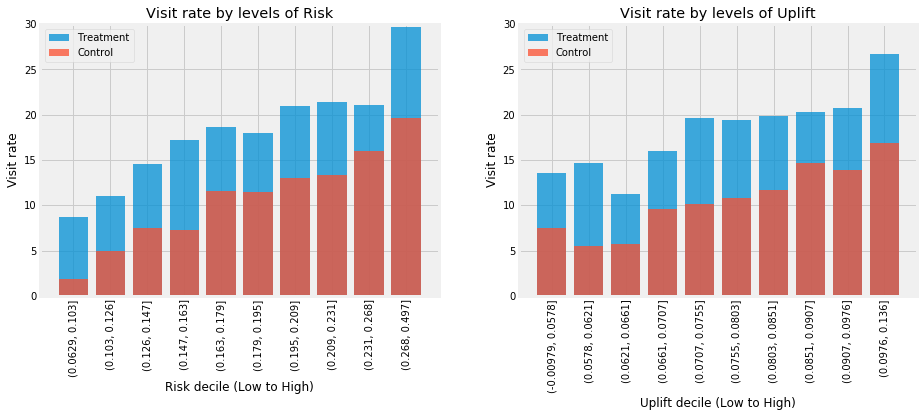

In [30]:
risk_treatment, risk_control = compute_visit_rates(results_df)
uplift_treatment, uplift_control = compute_visit_rates(results_df, for_risk=False)

fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.bar(risk_treatment.risk_decile.values, risk_treatment.visit_rate.values, label='Treatment', alpha=0.75)
ax1.bar(risk_control.risk_decile.values, risk_control.visit_rate.values, label='Control', alpha=0.75)
ax1.set_ylabel("Visit rate")
ax1.set_xlabel("Risk decile (Low to High)")
ax1.legend()
plt.xticks(rotation='vertical')
ax1.set_title("Visit rate by levels of Risk")
ax1.set_ylim(0,30)

ax2 = fig.add_subplot(122)
ax2.bar(uplift_treatment.uplift_decile.values, uplift_treatment.visit_rate.values, label='Treatment', alpha=0.75)
ax2.bar(uplift_control.uplift_decile.values, uplift_control.visit_rate.values, label='Control', alpha=0.75)
ax2.set_ylabel("Visit rate")
ax2.set_xlabel("Uplift decile (Low to High)")
ax2.legend()
plt.xticks(rotation='vertical')
ax2.set_title("Visit rate by levels of Uplift")
ax2.set_ylim(0,30);

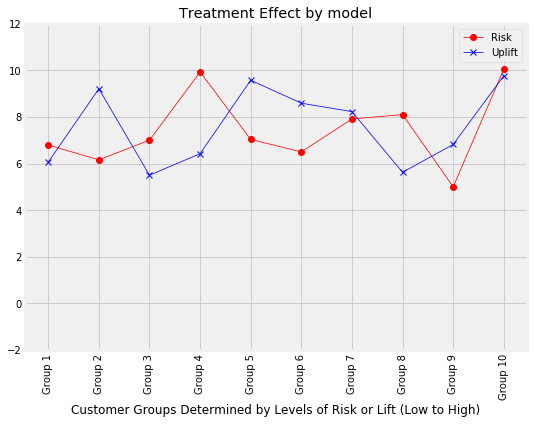

In [31]:
group_labels = ['Group ' + str(group) for group in list(range(1,11))]
risk_te = compute_treatment_effect(results_df)
risk_te['group'] = group_labels
uplift_te = compute_treatment_effect(results_df, for_risk=False)
uplift_te['group'] = group_labels

plt.figure(figsize=(8,6))
plt.plot(risk_te.group.values, risk_te.Treatment_Effect.values, 'ro-', linewidth=0.75, label='Risk')
plt.plot(uplift_te.group.values, uplift_te.Treatment_Effect.values, 'bx-', linewidth=0.75, label='Uplift')
plt.ylim(-2,12)
plt.xticks(rotation='vertical')
plt.xlabel("Customer Groups Determined by Levels of Risk or Lift (Low to High)")
plt.legend()
plt.title("Treatment Effect by model");

In [32]:
risk_impact_df, _, _ = compute_impact(results_df, for_risk=True)
uplift_impact_df, _, _ = compute_impact(results_df, for_risk=False)

group_labels = [str(group*10)+'%' for group in list(range(1,11))]
risk_impact_df['group'] = group_labels
uplift_impact_df['group'] = group_labels

Average Treatment Effect in test data

In [33]:
womens = results_df[results_df.Treatment==1].Outcome.mean()*100
control = results_df[results_df.Treatment==0].Outcome.mean()*100
ate_test = womens-control
print("Men's visit rate uplift: {:.2f}%".format(ate_test))
del womens, control

Men's visit rate uplift: 7.57%


This is the expected visit rate uplift when randomly targeting customers

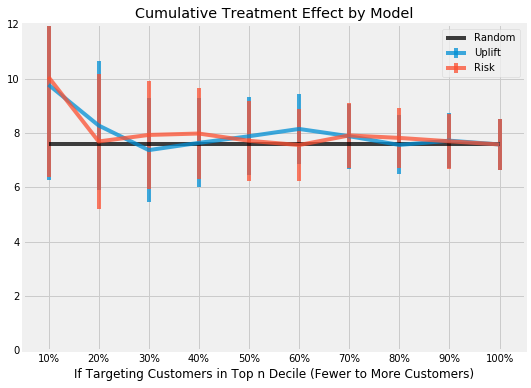

In [34]:
plt.figure(figsize=(8,6))
plt.errorbar(uplift_impact_df.group, uplift_impact_df.cumsum_treatment_effect*100, (uplift_impact_df.standard_error*100*1.96), label='Uplift', alpha=0.75)
plt.errorbar(risk_impact_df.group, risk_impact_df.cumsum_treatment_effect*100, (risk_impact_df.standard_error*100*1.96), label='Risk', alpha=0.75)
plt.ylim(0,12)
plt.xlabel("If Targeting Customers in Top n Decile (Fewer to More Customers)")
plt.hlines(ate_test, 0, 9, label='Random', alpha=0.75)
plt.xlim(-0.5,9.5)
plt.title("Cumulative Treatment Effect by Model")
plt.legend();

In [ ]:
feat_names = list(results_df.drop(columns=['TransformedOutcome', 'Treatment', 'Outcome', 'risk', 'uplift', 'risk_decile']).columns)

avg_by_uplift_decile = results_df[feat_names].groupby('uplift_decile').mean().reset_index()
columns = []
feats = []
for col in avg_by_uplift_decile.columns:
    if col[1] == '':
        columns.append(col[0])
    else:
        feats.append(col[0])
        columns.append(col[0]+'_'+col[1])

avg_by_uplift_decile['uplift_decile'] = avg_by_uplift_decile['uplift_decile'].astype(str)
group_labels = ['Group ' + str(group) for group in list(range(1,11))]
avg_by_uplift_decile['group'] = group_labels
avg_by_uplift_decile = avg_by_uplift_decile.iloc[::-1]


fig = plt.figure(figsize=(16,12))
for idx, col in enumerate(avg_by_uplift_decile.iloc[:,1:13]):
    ax = fig.add_subplot(3,4,idx+1)
    ax.set_xlabel('Decile Groups (High Uplift to Low Uplift)')
    ax.set_title(col)
    ax.plot(avg_by_uplift_decile.group, avg_by_uplift_decile[col], 'bx-', linewidth=1, alpha=0.75)
    plt.xticks(rotation='vertical')
    plt.hlines(results_df[col].mean(), 0, 9, label='Average', alpha=0.75, linewidth=1.5)
    plt.legend()
plt.tight_layout()